In [68]:
# import useful libraries

# standard
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import sys
import random

# classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# reduction techniques
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import KernelPCA
import CST as cst

# preprocessing and transformation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# analysis
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
import time

These experiments will exist to show across all hyperparameter values for all DR techniques used, that CST's sole reduction is more or equally as optimal than any other hyperparameter value for all other methods

The dataset we will use here is distinguising whether or not a given cancerous patient has either a carcinomic cancer or an adenocarcinomic cancer (experiment 5 in the newExperiments_v5.ipynb file)

We will create a method that generates a BAC value for each hyperparam value for each reduction method. This figure will be generated for each classifier (6 figures total)

In [69]:
# read in data
df_pos5 = pd.read_csv('../preprocessedData_reduced/carcinomas_v_adenocarcinomas_reduced_pos_samples.tsv', sep='\t', header=0)
df_pos5 = df_pos5.set_index(df_pos5.iloc[:,0])
df_pos5 = df_pos5.iloc[:, 1:]

df_neg5 = pd.read_csv('../preprocessedData_reduced/carcinomas_v_adenocarcinomas_reduced_neg_samples.tsv', sep='\t', header=0)
df_neg5 = df_neg5.set_index(df_neg5.iloc[:,0])
df_neg5 = df_neg5.iloc[:, 1:]

In [70]:
pos5 = df_pos5.sample(200, replace=False, random_state=1062601)
neg5 = df_neg5.sample(200, replace=False, random_state=1062601)

In [4]:
# run full experiments (not including CST)

In [35]:
def experiments_BACs_nonCST(X_train, X_test, y_train, y_test, k):
    
    pca = PCA(n_components = k)
    pca.fit(X_train)
    X_train_trans = pca.transform(X_train)
    X_test_trans = pca.transform(X_test)
    pca_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    selectKBest = SelectKBest(score_func=mutual_info_classif, k=k)
    selectKBest.fit(X_train, y_train)
    X_train_trans = selectKBest.transform(X_train)
    X_test_trans = selectKBest.transform(X_test)
    mi_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    mapper = umap.UMAP(n_components=k).fit(X_train, y_train) # may need to fix this
    X_train_trans = mapper.transform(X_train)
    X_test_trans = mapper.transform(X_test)
    umap_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    kpca = KernelPCA(n_components = k, kernel = 'poly')
    kpca.fit(X_train)
    X_train_trans = kpca.transform(X_train)
    X_test_trans = kpca.transform(X_test)
    kpca_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    return  pca_bacs, mi_bacs, umap_bacs, kpca_bacs
    

In [36]:
def experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k):
    
    temp_BACs = np.zeros(6)
    
    neighbors = KNeighborsClassifier(n_neighbors=3)
    neighbors.fit(X_train_trans, y_train)
    temp_BACs[0] = balanced_accuracy_score(y_test, neighbors.predict(X_test_trans))
    
    svm = SVC(kernel='linear', C=1)
    svm.fit(X_train_trans, y_train)
    temp_BACs[1] = balanced_accuracy_score(y_test, svm.predict(X_test_trans))
    
    gnb = GaussianNB()
    gnb.fit(X_train_trans, y_train)
    temp_BACs[2] = balanced_accuracy_score(y_test, gnb.predict(X_test_trans))
    
    rf = RandomForestClassifier(random_state=137)
    rf.fit(X_train_trans, y_train)
    temp_BACs[3] = balanced_accuracy_score(y_test, rf.predict(X_test_trans))
    
    sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    sgd.fit(X_train_trans, y_train)
    temp_BACs[4] = balanced_accuracy_score(y_test, sgd.predict(X_test_trans))
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_trans, y_train)
    temp_BACs[5] = balanced_accuracy_score(y_test, lda.predict(X_test_trans))
    
    return temp_BACs
    

In [37]:
#checks out bc 50 total iterations from for loops and each iteration conducts 30 ML experiments
def runexperiments_full_2(g1_samples, g2_samples, k):
    
    x = pd.concat([g1_samples, g2_samples]) #add together all postiive and negative labels 
    x = StandardScaler().fit_transform(x) #standardize values in x (z-score standardization)

    target_g1 = pd.DataFrame(np.zeros((len(g1_samples), 1))) #get number of target group 1
    target_g2 = pd.DataFrame(np.ones((len(g2_samples), 1))) #get number of target group 2

    target = pd.concat([target_g1, target_g2]) #concatenate target zeros ones twos etc together
    target = target.reset_index(drop=True)
    
    splits_rats = np.array([.1, .15, .2, .25, .3])

    BAC_sums_pca = np.zeros(6)
    BAC_sums_mi = np.zeros(6)
    BAC_sums_umap = np.zeros(6)
    BAC_sums_kpca = np.zeros(6)
    
    split_num = 5
    
    for i in splits_rats:
        #split the data into test and train
        X_train, X_test, y_train, y_test = train_test_split(x, target.to_numpy(), test_size=i, random_state=42)
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        
        kf = KFold(n_splits=split_num, shuffle=True, random_state=42)
        
        for trainIn, valIn in kf.split(X_train):
        
            x_train_nonval = X_train[trainIn]
            y_train_nonval = y_train[trainIn]

            x_val = X_train[valIn]
            y_val = y_train[valIn]
            
            x_temp = np.concatenate((x_val,X_test), axis=0)
            y_temp = np.concatenate((y_val,y_test), axis=0)
            
            t2, t3, t4, t5 = experiments_BACs_nonCST(x_train_nonval, x_temp, y_train_nonval, y_temp, k)
            BAC_sums_pca += t2
            BAC_sums_mi += t3
            BAC_sums_umap += t4
            BAC_sums_kpca += t5
    
    numIter = splits_rats.shape[0]*split_num
    BAC_sums_pca /= numIter
    BAC_sums_mi /= numIter
    BAC_sums_umap /= numIter
    BAC_sums_kpca /= numIter    
    
    return BAC_sums_pca, BAC_sums_mi, BAC_sums_umap, BAC_sums_kpca
    

In [38]:
def getAllNonCSTValues(pos,neg):
    dictTracker = {}
    for i in range(2,203,10):
        exp_pca, exp_mi, exp_umap, exp_kpca = runexperiments_full_2(pos, neg, i)
        dictTracker[i] = [exp_pca, exp_mi, exp_umap, exp_kpca]
    return dictTracker

In [39]:
start = time.time()
nonCST_vals = getAllNonCSTValues(pos5, neg5)
end = time.time()
print("Time taken for non-CST experiments", end-start)

Time taken for non-CST experiments 5872.701520681381


In [40]:
nonCST_vals

{2: [array([0.90289261, 0.89865677, 0.68974783, 0.90767966, 0.87699764,
         0.66421153]),
  array([0.9197515 , 0.94094796, 0.93191489, 0.91913275, 0.92095069,
         0.92797188]),
  array([0.95215798, 0.95215798, 0.95342926, 0.95160804, 0.9475175 ,
         0.94794643]),
  array([0.77375094, 0.50742839, 0.5716754 , 0.78674381, 0.51446589,
         0.49712888])],
 12: [array([0.97605103, 0.96313717, 0.7975639 , 0.97432131, 0.94978701,
         0.91917585]),
  array([0.95625232, 0.95532734, 0.94404994, 0.96087251, 0.94515888,
         0.953603  ]),
  array([0.94982283, 0.94982283, 0.95651345, 0.95312831, 0.95141817,
         0.94873242]),
  array([0.96627629, 0.81940908, 0.66459537, 0.96239248, 0.87159544,
         0.70772104])],
 22: [array([0.96738155, 0.96531126, 0.76989136, 0.97178699, 0.95970649,
         0.96757093]),
  array([0.96071668, 0.96159496, 0.93836095, 0.96272728, 0.95534782,
         0.96038849]),
  array([0.94898989, 0.94926017, 0.95499336, 0.95149655, 0.94987326

In [ ]:
# run CST experiment

In [20]:
def experiments_BACs_CST(X_train, X_test, y_train, y_test, k):
    
    #CST goes here
    X_train_trans, f = CST_fit(X_train, y_train)
    X_test_trans = CST_transform(X_test, f)
    cst_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, 2)
    
    return  cst_bacs
    

In [30]:
from sklearn.model_selection import KFold

In [21]:
#checks out bc 50 total iterations from for loops and each iteration conducts 30 ML experiments
def runexperiments_full_2_CST(g1_samples, g2_samples):
    
    x = pd.concat([g1_samples, g2_samples]) #add together all postiive and negative labels 
    x = StandardScaler().fit_transform(x) #standardize values in x (z-score standardization)

    target_g1 = pd.DataFrame(np.zeros((len(g1_samples), 1))) #get number of target group 1
    target_g2 = pd.DataFrame(np.ones((len(g2_samples), 1))) #get number of target group 2

    target = pd.concat([target_g1, target_g2]) #concatenate target zeros ones twos etc together
    target = target.reset_index(drop=True)
    
    splits_rats = np.array([.1, .15, .2, .25, .3])

    BAC_sums_cst = np.zeros(6)
    
    for i in splits_rats:
        #split the data into test and train
        X_train, X_test, y_train, y_test = train_test_split(x, target.to_numpy(), test_size=i, random_state=42)
        y_train = y_train.ravel()
        y_test = y_test.ravel()
            
        t1 = experiments_BACs_CST(X_train, X_test, y_train, y_test, 2)
        BAC_sums_cst += t1
    
    numIter = splits_rats.shape[0]
    BAC_sums_cst /= numIter   
    
    return BAC_sums_cst
    

In [18]:
CST_vals = runexperiments_full_2_CST(pos5, neg5)

In [19]:
CST_vals

array([0.96777366, 0.96777366, 0.96777366, 0.96491652, 0.95940252,
       0.95392994])

In [15]:
primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

In [29]:
start = time.time()
highest_mean = 0
best_CST_vals = None
ideal_random_state = None
for i in primes:
    pos5 = df_pos5.sample(200, replace=False, random_state=i)
    neg5 = df_neg5.sample(200, replace=False, random_state=i)
    temp_CST_vals = runexperiments_full_2_CST(pos5, neg5)
    if np.mean(temp_CST_vals) > highest_mean:
        highest_mean = np.mean(temp_CST_vals)
        best_CST_vals = temp_CST_vals
        ideal_random_state = i
end = time.time()
print("Time taken for CST optimizing random state is", end-start)
print(ideal_random_state)
print(best_CST_vals)
print(highest_mean)

Time taken for CST optimizing random state is 33114.59292912483
59
[1.         1.         1.         0.99120086 0.99655172 0.9706219 ]
0.993062414278473


In [54]:
pos5 = df_pos5.sample(200, replace=False, random_state=59)
neg5 = df_neg5.sample(200, replace=False, random_state=59)
best_CST_vals = runexperiments_full_2_CST(pos5, neg5)
print(best_CST_vals)

[1.         1.         1.         0.99120086 0.99583333 0.9706219 ]


In [27]:
#transform X into X_trans using CST algorithm
def CST_fit(X, y):
    
    #construct upper triangular A
    sampleNum = X.shape[0] #get the number of samples
    featureNum = X.shape[1] #get the number of features
    temp_A = np.zeros((featureNum, featureNum)) #A has dimensions nxn, devised from outer product of difference of two samples's feature values
    
    #loops over SxS where S:{1,m} (m = # of samples)
    for i in range(sampleNum-1):
        #print("Progess:", i)
        start = time.time()
        for j in range(i+1, sampleNum):
            
            #I think I need a condition that says as long as i != j 
            #(actually don't because it's adding 0's, eliminating saves flops though)
            sample_difference = X[i] - X[j]
            
            #if indicator_func(y,i,j) == 1:
            if y[i] == y[j]:
                temp_A += (np.outer(sample_difference, sample_difference.T))
            else:
                temp_A -= (np.outer(sample_difference, sample_difference.T))
            
                #sample_dif_sqrd = sample_difference.reshape(-1,1) @ sample_difference.reshape(-1,1).T
                #temp_A[i][j] = indicator_func(y, i, j)*sample_dif_sqrd
                #temp_A += indicator_func(y, i, j)*sample_dif_sqrd
        end = time.time()
        #print("Time for iteration:", i, "is", end - start)
#         if i % 10 == 0:
#             print("progress at", i)
    
    #make matrix symmetric
    #A = np.where(temp_A, temp_A, temp_A.T)
    #print(temp_A) #prints the A matrix to make sure it is symmetric
    
    #calculate eigenvalues and eigenvectors of A
    eigvals, eigvecs = np.linalg.eig(temp_A)
    
    #get minimum eigenvector
    min_ind = np.argmin(eigvals)
    min_eigvec = eigvecs[:,min_ind] #in the algorithm, this is the vector f
    
    #transform the data
    X_trans = X @ min_eigvec 
    
    return np.real(X_trans).reshape(-1,1), np.real(min_eigvec)
    

In [28]:
def CST_transform(X, f):
    
    #transform the data
    X_trans = X @ f
    
    return X_trans.reshape(-1,1)
    

In [42]:
# concatentate experiment values
for i in range(2,203,10):
    nonCST_vals[i].append(best_CST_vals)

In [43]:
nonCST_vals

{2: [array([0.90289261, 0.89865677, 0.68974783, 0.90767966, 0.87699764,
         0.66421153]),
  array([0.9197515 , 0.94094796, 0.93191489, 0.91913275, 0.92095069,
         0.92797188]),
  array([0.95215798, 0.95215798, 0.95342926, 0.95160804, 0.9475175 ,
         0.94794643]),
  array([0.77375094, 0.50742839, 0.5716754 , 0.78674381, 0.51446589,
         0.49712888]),
  array([1.        , 1.        , 1.        , 0.99120086, 0.99655172,
         0.9706219 ])],
 12: [array([0.97605103, 0.96313717, 0.7975639 , 0.97432131, 0.94978701,
         0.91917585]),
  array([0.95625232, 0.95532734, 0.94404994, 0.96087251, 0.94515888,
         0.953603  ]),
  array([0.94982283, 0.94982283, 0.95651345, 0.95312831, 0.95141817,
         0.94873242]),
  array([0.96627629, 0.81940908, 0.66459537, 0.96239248, 0.87159544,
         0.70772104]),
  array([1.        , 1.        , 1.        , 0.99120086, 0.99655172,
         0.9706219 ])],
 22: [array([0.96738155, 0.96531126, 0.76989136, 0.97178699, 0.95970649

In [28]:
nonCST_vals[2][0][0]

0.9364230748240759

In [47]:
# generate lists for each classifier
# order of the DR techniques in the dict are: PCA, MI, UMAP, KPCA, CST
# order of the classifiers in the arrays are: KNN, SVM, GNB, RF, SGD, LDA
feature_ticks = list(range(2,203,10))

PCA_KNN = []
PCA_SVM = []
PCA_GNB = []
PCA_RF = []
PCA_SGD = []
PCA_LDA = []

MI_KNN = []
MI_SVM = []
MI_GNB = []
MI_RF = []
MI_SGD = []
MI_LDA = []

UMAP_KNN = []
UMAP_SVM = []
UMAP_GNB = []
UMAP_RF = []
UMAP_SGD = []
UMAP_LDA = []

KPCA_KNN = []
KPCA_SVM = []
KPCA_GNB = []
KPCA_RF = []
KPCA_SGD = []
KPCA_LDA = []

CST_KNN = []
CST_SVM = []
CST_GNB = []
CST_RF = []
CST_SGD = []
CST_LDA = []

for i in range(2,203,10):
    PCA_KNN.append(nonCST_vals[i][0][0])
    PCA_SVM.append(nonCST_vals[i][0][1])
    PCA_GNB.append(nonCST_vals[i][0][2])
    PCA_RF.append(nonCST_vals[i][0][3])
    PCA_SGD.append(nonCST_vals[i][0][4])
    PCA_LDA.append(nonCST_vals[i][0][5])

    MI_KNN.append(nonCST_vals[i][1][0])
    MI_SVM.append(nonCST_vals[i][1][1])
    MI_GNB.append(nonCST_vals[i][1][2])
    MI_RF.append(nonCST_vals[i][1][3])
    MI_SGD.append(nonCST_vals[i][1][4])
    MI_LDA.append(nonCST_vals[i][1][5])

    UMAP_KNN.append(nonCST_vals[i][2][0])
    UMAP_SVM.append(nonCST_vals[i][2][1])
    UMAP_GNB.append(nonCST_vals[i][2][2])
    UMAP_RF.append(nonCST_vals[i][2][3])
    UMAP_SGD.append(nonCST_vals[i][2][4])
    UMAP_LDA.append(nonCST_vals[i][2][5])

    KPCA_KNN.append(nonCST_vals[i][3][0])
    KPCA_SVM.append(nonCST_vals[i][3][1])
    KPCA_GNB.append(nonCST_vals[i][3][2])
    KPCA_RF.append(nonCST_vals[i][3][3])
    KPCA_SGD.append(nonCST_vals[i][3][4])
    KPCA_LDA.append(nonCST_vals[i][3][5])

    CST_KNN.append(nonCST_vals[i][4][0])
    CST_SVM.append(nonCST_vals[i][4][1])
    CST_GNB.append(nonCST_vals[i][4][2])
    CST_RF.append(nonCST_vals[i][4][3])
    CST_SGD.append(nonCST_vals[i][4][4])
    CST_LDA.append(nonCST_vals[i][4][5])


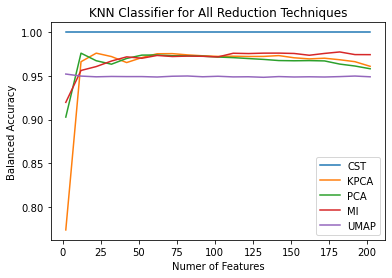

In [74]:
plt.title("KNN Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_KNN, label = "CST")
plt.plot(feature_ticks, KPCA_KNN, label = "KPCA")
plt.plot(feature_ticks, PCA_KNN, label = "PCA")
plt.plot(feature_ticks, MI_KNN, label = "MI")
plt.plot(feature_ticks, UMAP_KNN, label = "UMAP")
plt.legend()
plt.savefig('figures/hypertune_knn.png')
plt.show()

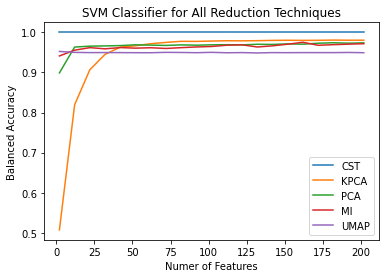

In [75]:
plt.title("SVM Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_SVM, label = "CST")
plt.plot(feature_ticks, KPCA_SVM, label = "KPCA")
plt.plot(feature_ticks, PCA_SVM, label = "PCA")
plt.plot(feature_ticks, MI_SVM, label = "MI")
plt.plot(feature_ticks, UMAP_SVM, label = "UMAP")
plt.legend()
plt.savefig('figures/hypertune_svm.png')
plt.show()

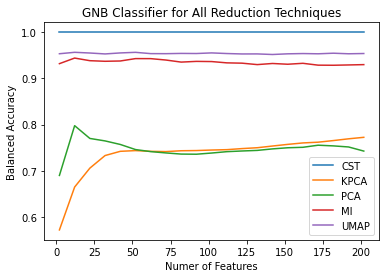

In [77]:
plt.title("GNB Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_GNB, label = "CST")
plt.plot(feature_ticks, KPCA_GNB, label = "KPCA")
plt.plot(feature_ticks, PCA_GNB, label = "PCA")
plt.plot(feature_ticks, MI_GNB, label = "MI")
plt.plot(feature_ticks, UMAP_GNB, label = "UMAP")
plt.legend()
plt.savefig('figures/hypertune_gnb.png')
plt.show()

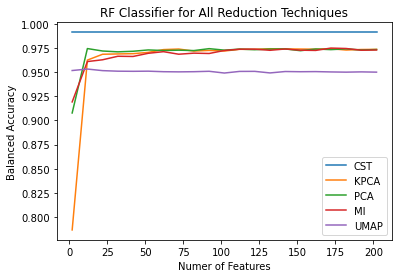

In [78]:
plt.title("RF Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_RF, label = "CST")
plt.plot(feature_ticks, KPCA_RF, label = "KPCA")
plt.plot(feature_ticks, PCA_RF, label = "PCA")
plt.plot(feature_ticks, MI_RF, label = "MI")
plt.plot(feature_ticks, UMAP_RF, label = "UMAP")
plt.legend()
plt.savefig('figures/hypertune_rf.png')
plt.show()

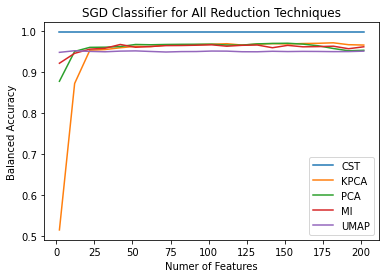

In [79]:
plt.title("SGD Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_SGD, label = "CST")
plt.plot(feature_ticks, KPCA_SGD, label = "KPCA")
plt.plot(feature_ticks, PCA_SGD, label = "PCA")
plt.plot(feature_ticks, MI_SGD, label = "MI")
plt.plot(feature_ticks, UMAP_SGD, label = "UMAP")
plt.legend()
plt.savefig('figures/hypertune_sgd.png')
plt.show()

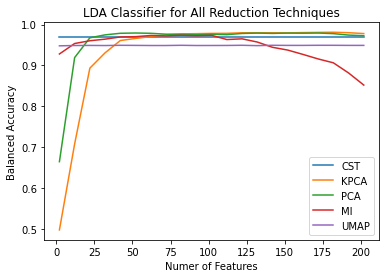

In [80]:
plt.title("LDA Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_LDA, label = "CST")
plt.plot(feature_ticks, KPCA_LDA, label = "KPCA")
plt.plot(feature_ticks, PCA_LDA, label = "PCA")
plt.plot(feature_ticks, MI_LDA, label = "MI")
plt.plot(feature_ticks, UMAP_LDA, label = "UMAP")
plt.legend()
plt.savefig('figures/hypertune_lda.png')
plt.show()

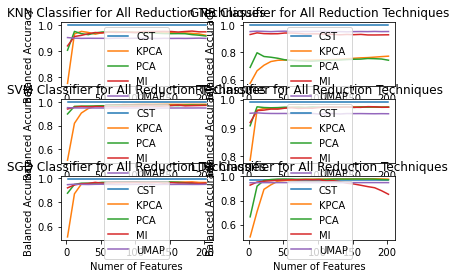

In [67]:
plt.subplot(3, 2, 1)
plt.title("KNN Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_KNN, label = "CST")
plt.plot(feature_ticks, KPCA_KNN, label = "KPCA")
plt.plot(feature_ticks, PCA_KNN, label = "PCA")
plt.plot(feature_ticks, MI_KNN, label = "MI")
plt.plot(feature_ticks, UMAP_KNN, label = "UMAP")
plt.legend()

plt.subplot(3, 2, 2)
plt.title("GNB Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_GNB, label = "CST")
plt.plot(feature_ticks, KPCA_GNB, label = "KPCA")
plt.plot(feature_ticks, PCA_GNB, label = "PCA")
plt.plot(feature_ticks, MI_GNB, label = "MI")
plt.plot(feature_ticks, UMAP_GNB, label = "UMAP")
plt.legend()

plt.subplot(3, 2, 3)
plt.title("SVM Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_SVM, label = "CST")
plt.plot(feature_ticks, KPCA_SVM, label = "KPCA")
plt.plot(feature_ticks, PCA_SVM, label = "PCA")
plt.plot(feature_ticks, MI_SVM, label = "MI")
plt.plot(feature_ticks, UMAP_SVM, label = "UMAP")
plt.legend()

plt.subplot(3, 2, 4)
plt.title("RF Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_RF, label = "CST")
plt.plot(feature_ticks, KPCA_RF, label = "KPCA")
plt.plot(feature_ticks, PCA_RF, label = "PCA")
plt.plot(feature_ticks, MI_RF, label = "MI")
plt.plot(feature_ticks, UMAP_RF, label = "UMAP")
plt.legend()

plt.subplot(3, 2, 5)
plt.title("SGD Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_SGD, label = "CST")
plt.plot(feature_ticks, KPCA_SGD, label = "KPCA")
plt.plot(feature_ticks, PCA_SGD, label = "PCA")
plt.plot(feature_ticks, MI_SGD, label = "MI")
plt.plot(feature_ticks, UMAP_SGD, label = "UMAP")
plt.legend()

plt.subplot(3, 2, 6)
plt.title("LDA Classifier for All Reduction Techniques")
plt.xlabel("Numer of Features")
plt.ylabel("Balanced Accuracy")
plt.plot(feature_ticks, CST_LDA, label = "CST")
plt.plot(feature_ticks, KPCA_LDA, label = "KPCA")
plt.plot(feature_ticks, PCA_LDA, label = "PCA")
plt.plot(feature_ticks, MI_LDA, label = "MI")
plt.plot(feature_ticks, UMAP_LDA, label = "UMAP")
plt.legend()

plt.show()

In [ ]:
#plot 1:
x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(1, 2, 1)
plt.plot(x,y)
plt.title("SALES")

#plot 2:
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(1, 2, 2)
plt.plot(x,y)
plt.title("INCOME")

plt.show()

In [ ]:
# method to graph




In [ ]:
# pass results to graph method to get diagram to use in the paper

In [9]:
# how one calls the CST class from the module
obj = cst.CST()